#### Import Package Dependencies

In [1]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# package for hyperparameter tuning
import optuna

# user defined for visualization
from tutorial4 import coefplot
from tutorial9 import plot_feature_importance

print(f'Notebook tested on: \n')
print(f'numpy {np.__version__}')
print(f'pandas {pd.__version__}')
print(f'seaborn {sns.__version__}')
print(f'scikit-learn {sklearn.__version__}')

Notebook tested on: 

numpy 1.26.4
pandas 2.2.3
seaborn 0.13.2
scikit-learn 1.5.1


In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['figure.dpi'] = 80
%config InlineBackend.figure_format = 'retina'

#### Import Training and Testing Sets

In [3]:
df_train = pd.read_csv('training_set_reg.csv')
df_test = pd.read_csv('testing_set_reg.csv')

df_train

,payment_value,price,freight_value,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,euclidean_distance,payment_type,...,product_category_name_english_Bed_bath_table,product_category_name_english_Computer_accessories,product_category_name_english_Furniture_decor,product_category_name_english_Garden_tools,product_category_name_english_Health_beauty,product_category_name_english_Houseware,product_category_name_english_Others,product_category_name_english_Sports_leisure,product_category_name_english_Telephony,product_category_name_english_Watches_gifts
0,241,0.528475,0.117705,268.0,0.138228,0.663824,-0.644804,1.089971,7.806914,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,116,-0.422344,-0.316968,412.0,-0.454160,-0.820711,-0.718232,-0.941868,8.048100,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,95,-0.223798,-0.303169,2375.0,-0.196600,-0.016588,0.236325,0.243371,4.305249,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,134,-0.062059,0.297720,718.0,-0.454160,-0.016588,-0.865086,0.582011,12.490754,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,83,-0.276994,-0.439279,2026.0,-0.531428,-1.191845,-0.424522,-1.026528,2.631781,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86098,95,-0.459743,-0.520819,942.0,-0.409087,-0.264011,-0.130812,-0.433908,4.149282,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
86099,236,0.421008,1.051028,2261.0,3.692552,1.715369,0.823744,2.952489,1.324689,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
86100,98,-0.212514,-0.209084,965.0,-0.338258,-0.882567,1.117454,-0.603228,3.501271,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
86101,83,-0.315682,0.046200,1626.0,-0.512111,-0.820711,-0.497949,-0.349248,13.655855,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Sanity Check: Feature Set & Target Variables

In [4]:
### define target vector for training and testing set:
y_train = df_train['payment_value'].to_numpy()
y_test = df_test['payment_value'].to_numpy()

### define training and testing sets: feature set
X_train = df_train.drop(['payment_value','customer_id','order_id'], axis=1).copy()
X_test = df_test.drop(['payment_value','customer_id','order_id'], axis=1).copy()

print("Sanity check shape for training and testing set:")
print("------------------------------------------------------------------------------------------")
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Sanity check shape for training and testing set:
------------------------------------------------------------------------------------------
(86103, 28)
(36902, 28)
(86103,)
(36902,)


In [5]:
predictors = list(X_train.columns)
print(predictors)

['price', 'freight_value', 'product_description_lenght', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'euclidean_distance', 'payment_type', 'geolocation_state', 'customer_seller_loc', 'approving_time', 'processing_time', 'delivery_time', 'delivered_on_time', 'delivered_late', 'seller_on_time', 'order_completion_time', 'product_category_name_english_Bed_bath_table', 'product_category_name_english_Computer_accessories', 'product_category_name_english_Furniture_decor', 'product_category_name_english_Garden_tools', 'product_category_name_english_Health_beauty', 'product_category_name_english_Houseware', 'product_category_name_english_Others', 'product_category_name_english_Sports_leisure', 'product_category_name_english_Telephony', 'product_category_name_english_Watches_gifts']


#### Modeling Building: Regression

You must recommend three models:
* Baseline model (typically simple and interpretable)
* Best single model
* Model stack (or a simpler model combination)

##### 1. Linear Regression

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV

ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

In [7]:
y_pred = ols.predict(X_test)
y_fitted = ols.predict(X_train)
resid = y_train - y_fitted
resid

array([-64.60831277,  45.02473886, -82.20111836, ..., -27.00800909,
       -22.45978058, 316.87608418])

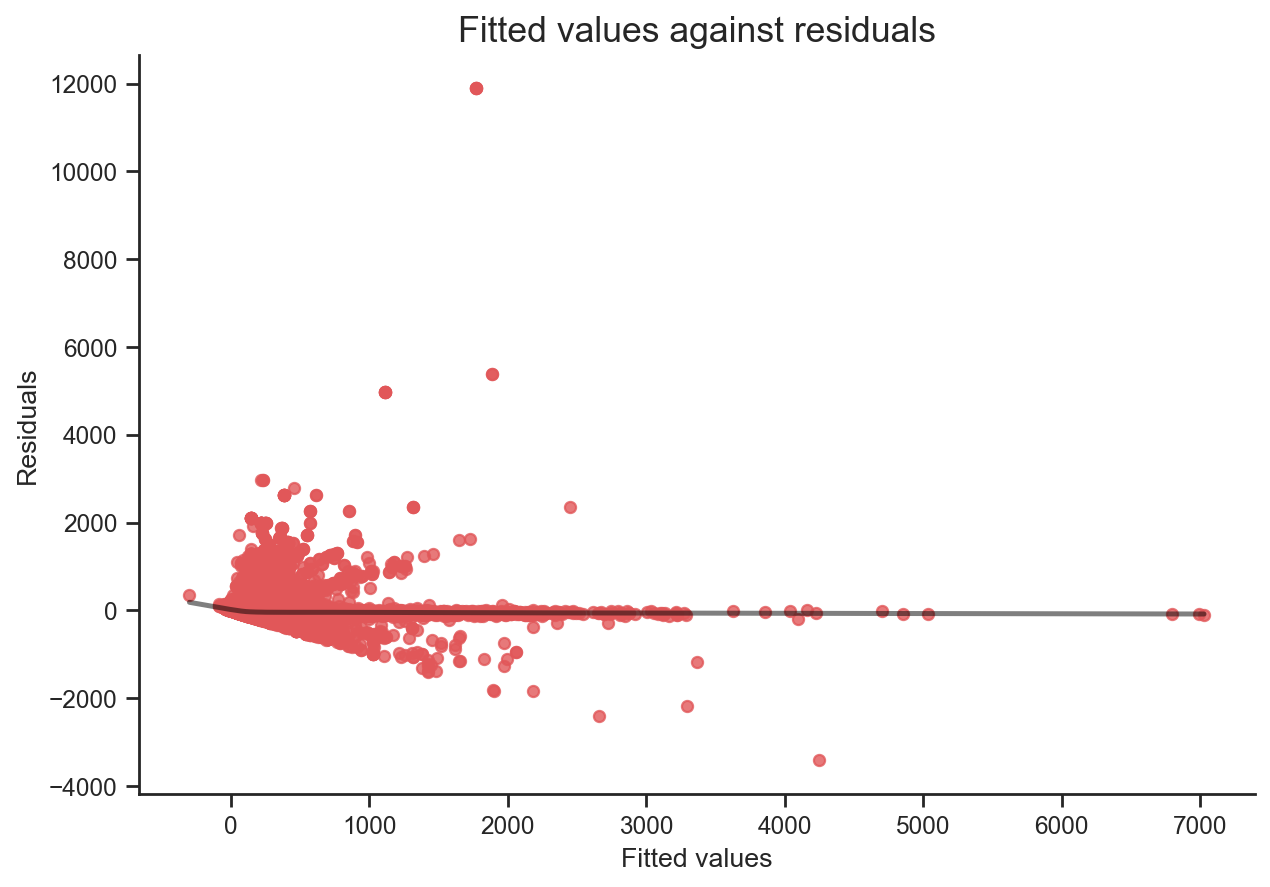

In [8]:
fig, ax = plt.subplots()
sns.regplot(x = y_fitted, y = resid, ci=None, lowess= True, scatter_kws={'s':25, 'color': colours[2]}, 
            line_kws={'color':'black', 'alpha':0.5})
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
ax.set_title('Fitted values against residuals', fontsize=16)
sns.despine()
plt.show()

##### 2. Ridge Regression (L2 Regularization)

In [9]:
alphas = 10 **np.linspace(10, -2, 100) * 0.5
print(alphas) # a complete 'list' of alphas

ridge = Ridge(random_state=62)
ridge.fit(X_train, y_train)
# ridge = RidgeCV(alphas=alphas, cv=5)

[5.00000000e+09 3.78231664e+09 2.86118383e+09 2.16438064e+09
 1.63727458e+09 1.23853818e+09 9.36908711e+08 7.08737081e+08
 5.36133611e+08 4.05565415e+08 3.06795364e+08 2.32079442e+08
 1.75559587e+08 1.32804389e+08 1.00461650e+08 7.59955541e+07
 5.74878498e+07 4.34874501e+07 3.28966612e+07 2.48851178e+07
 1.88246790e+07 1.42401793e+07 1.07721735e+07 8.14875417e+06
 6.16423370e+06 4.66301673e+06 3.52740116e+06 2.66834962e+06
 2.01850863e+06 1.52692775e+06 1.15506485e+06 8.73764200e+05
 6.60970574e+05 5.00000000e+05 3.78231664e+05 2.86118383e+05
 2.16438064e+05 1.63727458e+05 1.23853818e+05 9.36908711e+04
 7.08737081e+04 5.36133611e+04 4.05565415e+04 3.06795364e+04
 2.32079442e+04 1.75559587e+04 1.32804389e+04 1.00461650e+04
 7.59955541e+03 5.74878498e+03 4.34874501e+03 3.28966612e+03
 2.48851178e+03 1.88246790e+03 1.42401793e+03 1.07721735e+03
 8.14875417e+02 6.16423370e+02 4.66301673e+02 3.52740116e+02
 2.66834962e+02 2.01850863e+02 1.52692775e+02 1.15506485e+02
 8.73764200e+01 6.609705

Ridge(random_state=62)

##### 3. LASSO Regression (L1 Regularization)

In [10]:
alphas = list(np.logspace(-10, 10, 151, base=2))

lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

LassoCV(alphas=[0.0009765625, 0.0010711181442330329, 0.0011748291367989427,
                0.001288581944114155, 0.001413348864687869,
                0.0015501963398126943, 0.0017002940689377433,
                0.0018649250076375327, 0.002045496333634036,
                0.002243551474603583, 0.002460783300575925,
                0.002699048593687063, 0.0029603839189656206,
                0.003247023031807767, 0.0035614159709305357, 0.00390625,
                0.0042844725769321315, 0.004699316547195768,
                0.00515432777645662, 0.005653395458751476, 0.006200785359250777,
                0.006801176275750969, 0.007459700030550131,
                0.008181985334536145, 0.008974205898414337, 0.0098431332023037,
                0.010796194374748252, 0.011841535675862483,
                0.012988092127231059, 0.014245663883722143, ...],
        cv=5)

##### 4. KNN Regressor

In [13]:
from sklearn.neighbors import KNeighborsRegressor

knn1 = KNeighborsRegressor(n_neighbors = 5)
knn1.fit(X_train, y_train)

KNeighborsRegressor()

In [14]:
knn2 = KNeighborsRegressor(n_neighbors = 15) 
knn2.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=15)

In [15]:
# Sigma = np.cov(X_train, rowvar=False)

# knn3 = KNeighborsRegressor(n_neighbors = 15, metric='manhattan', 
#                           metric_params={'V': Sigma}) 
# knn3.fit(X_train, y_train)

##### Model Evaluation

In [16]:
# Initialize table
columns = ['RMSE', 'R-Squared', 'MAE']
rows = ['Linear Regression', 'Ridge', 'Lasso_CV', 'KNN (k = 5)', 'KNN (k = 15)']

results = pd.DataFrame(0.0, columns=columns, index=rows)
results

,RMSE,R-Squared,MAE
Linear Regression,0.0,0.0,0.0
Ridge,0.0,0.0,0.0
Lasso_CV,0.0,0.0,0.0
KNN (k = 5),0.0,0.0,0.0
KNN (k = 15),0.0,0.0,0.0


In [17]:
# Define Methods (All models)
methods = [ols, ridge, lasso_cv, knn1, knn2]

# Compute test predictions
#y_pred = np.zeros((len(y_valid), 3))

for i, method in enumerate(methods):
    
    y_pred = method.predict(X_test)
    
    # record validation results
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i, 1] = r2_score(y_test, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_test, y_pred)

results.round(3)

,RMSE,R-Squared,MAE
Linear Regression,194.508,0.521,62.498
Ridge,194.508,0.521,62.498
Lasso_CV,194.511,0.521,62.487
KNN (k = 5),177.363,0.602,85.337
KNN (k = 15),226.844,0.349,98.003


##### 5. Model Stack

In [18]:
from sklearn.ensemble import StackingRegressor

estimators = [
    ('Linear Regression', ols), 
    ('KNN', knn2),
    # ('Random Forest', rf)
]

stack = StackingRegressor(estimators = estimators, cv = 5,
                          final_estimator = LinearRegression(), # meta-model
                        )

stack.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('Linear Regression', LinearRegression()),
                              ('KNN', KNeighborsRegressor(n_neighbors=15))],
                  final_estimator=LinearRegression())

In [19]:
print(stack.final_estimator_.coef_)

[0.86154105 0.53048745]


##### 6. Tree-based Model: Decision Tree

In [20]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_leaf_nodes = 6)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=6)

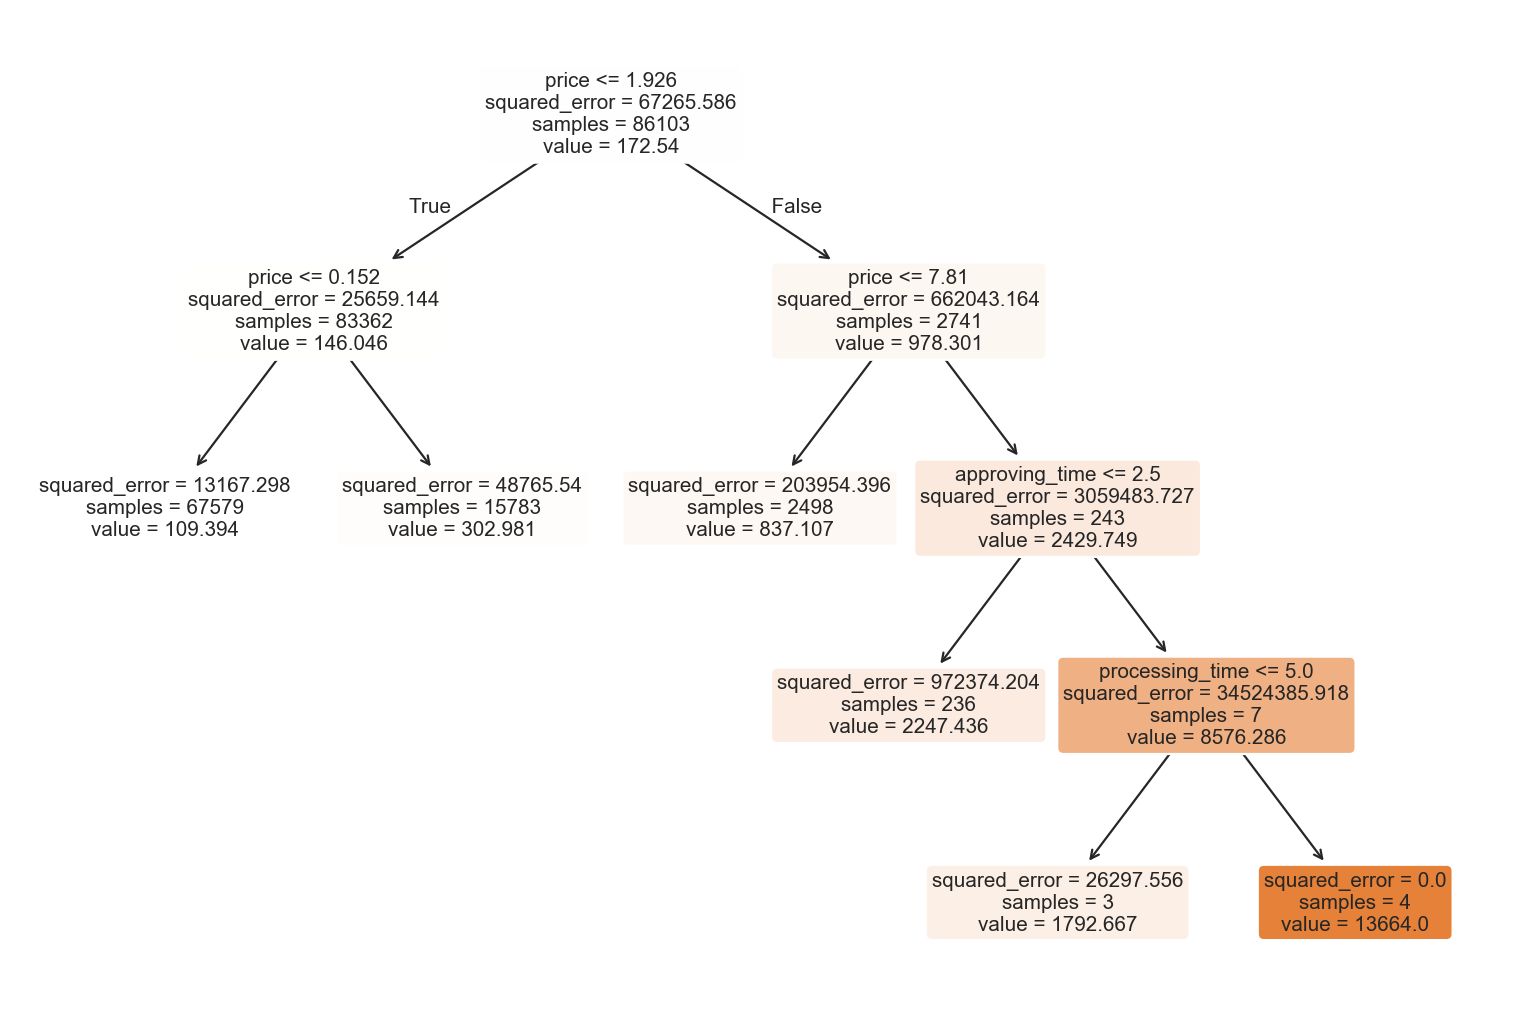

In [21]:
from sklearn import tree

plt.figure(figsize=(12, 8))
tree.plot_tree(dt, 
               feature_names=predictors,  # If you have feature names
               filled=True, 
               rounded=True)
plt.show()

##### 7. Bagging Regressor

In [22]:
from sklearn.ensemble import BaggingRegressor

bag = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=10, random_state=42)
bag.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(), random_state=42)

##### 8. Bagging: Random Forest

In [26]:
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    
    # criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_int('max_features', 1, 20)
    
    model = RandomForestRegressor(n_estimators = 500,  
                                  # criterion = criterion,  
                                  max_features = max_features, 
                                  min_samples_leaf= min_samples_leaf,
                                  random_state = 45)
    
    scores = cross_val_score(model, X_train, y_train, cv = 5, scoring='neg_mean_squared_error')
    loss = -np.mean(scores)
    
    return loss

sampler = TPESampler(seed=34) 
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials = 100, timeout = 120)

# the timeout should be as high as possible in a real application

[I 2025-05-03 20:25:39,314] A new study created in memory with name: no-name-29334956-352b-4308-802b-218ab9a4bc1f
[I 2025-05-03 20:42:38,675] Trial 0 finished with value: 6222.198432559554 and parameters: {'min_samples_leaf': 1, 'max_features': 16}. Best is trial 0 with value: 6222.198432559554.


In [27]:
params = study.best_params
print(params)

rf_tuned = RandomForestRegressor(n_estimators=100, **params)
rf_tuned.fit(X_train, y_train)

{'min_samples_leaf': 1, 'max_features': 16}


RandomForestRegressor(max_features=16)

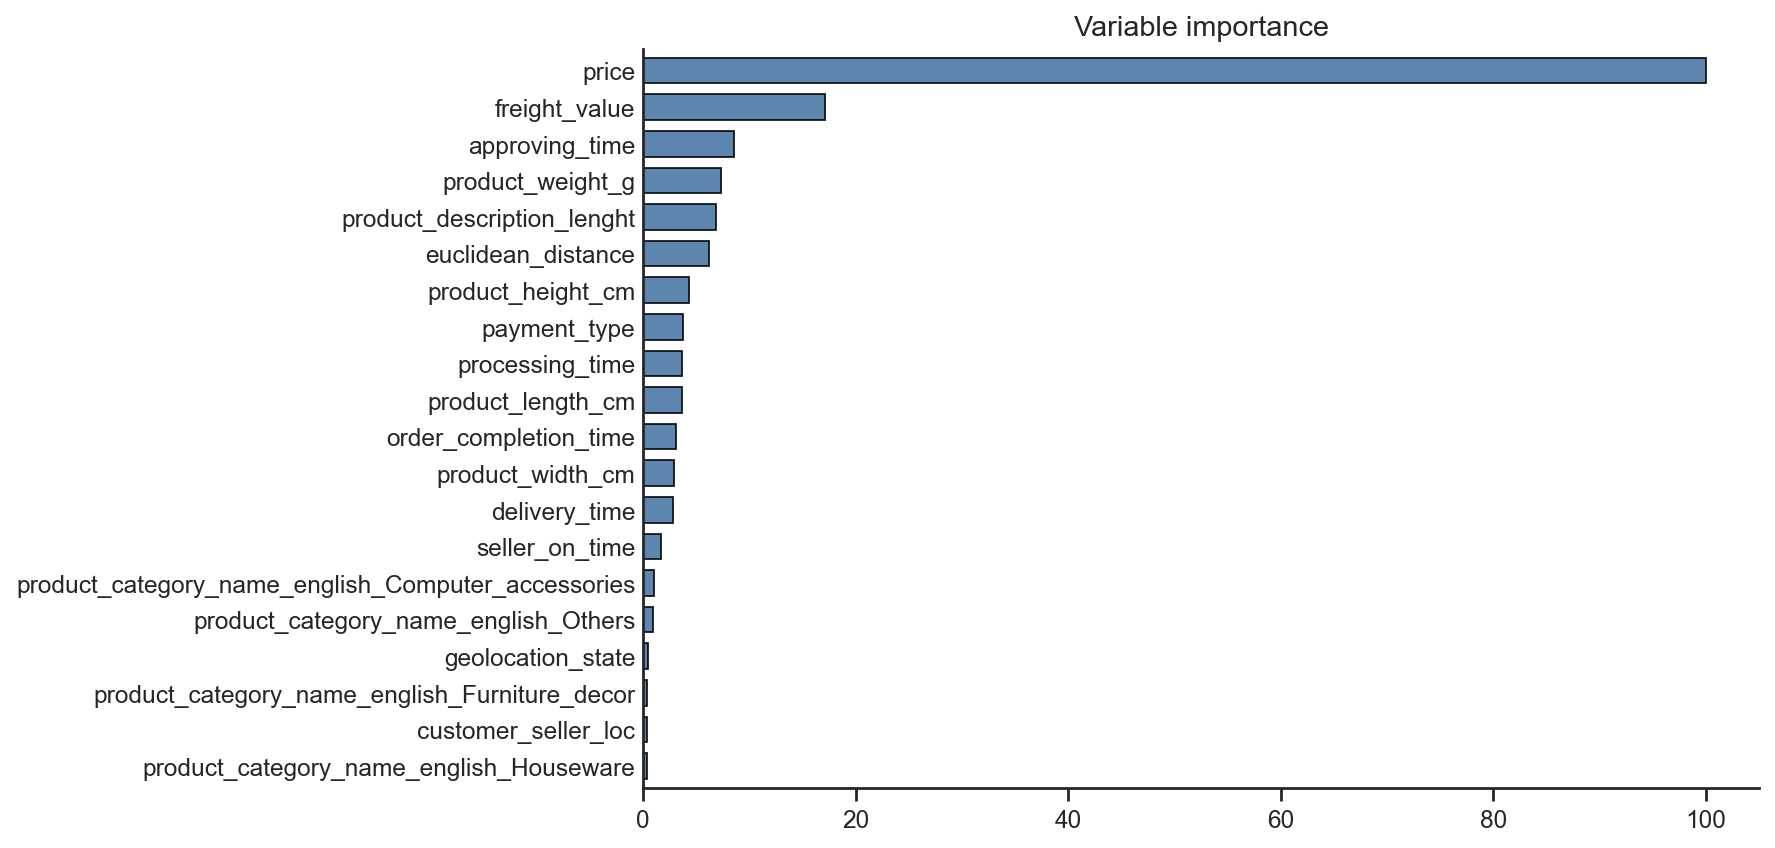

In [28]:
from tutorial9 import plot_feature_importance

plot_feature_importance(rf_tuned, predictors)
plt.show()

##### 9. Boosting: Gradient Boosting

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(learning_rate = 0.01, max_depth = 8, n_estimators = 500, subsample = 0.596)
gb.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=500,
                          subsample=0.596)

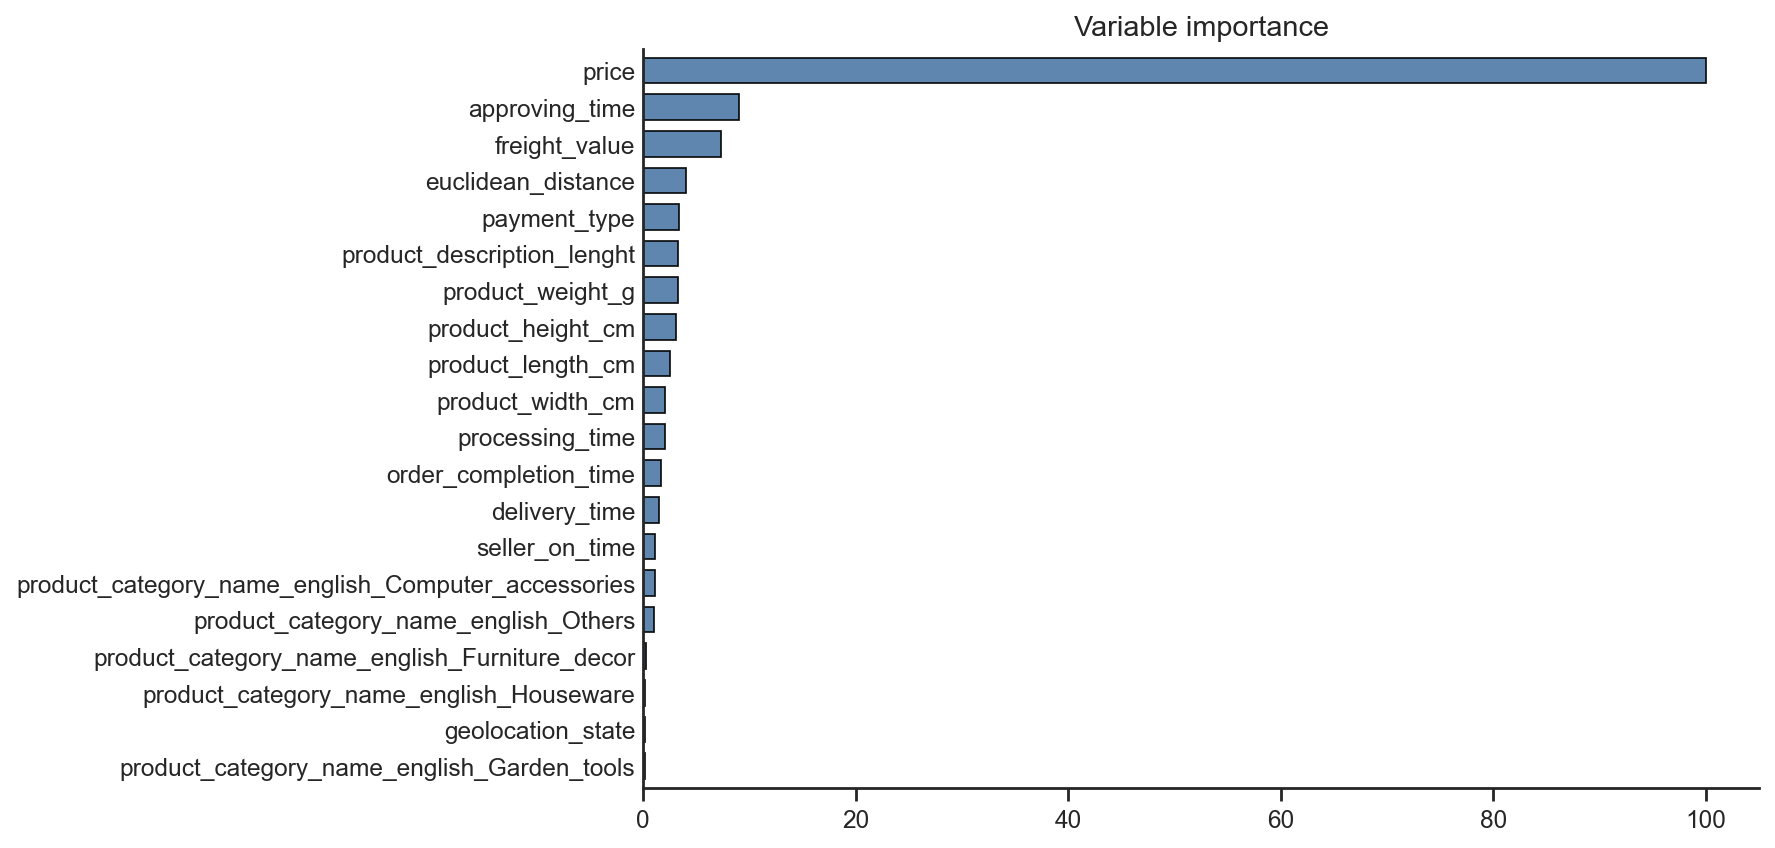

In [30]:
plot_feature_importance(gb, predictors)
plt.show()

##### 10. Boosting: AdaBoost

In [39]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(
    DecisionTreeRegressor(), n_estimators=50, random_state=42
)

ada.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(), random_state=42)

##### 11. Boosting: XGBoost

In [32]:
%%time
import xgboost as xgb

xgb = xgb.XGBRegressor(objective='reg:squarederror', booster = 'gbtree', learning_rate = 0.02, 
                        max_depth = 6, n_estimators = 1822, subsample = 0.60,  reg_lambda=0.0, 
                        reg_alpha = 0.0, colsample_bytree = 1.0, min_child_weight = 1.0)

# n_estimators: number of trees
# eta = learning rate
# subsample: fraction of observations used to fit each tree
# reg_lambda: L2 regularisation penalty
# reg_alpha: L1 regularisation penalty
# colsample_bytree: fraction of features considered for each tree (alternatives: bylevel, bynode)
# min_child_weight: approximately equal to the minimum number of samples in each node

xgb.fit(X_train, y_train)

CPU times: user 24.3 s, sys: 7.91 s, total: 32.2 s
Wall time: 3.71 s


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1822, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [82]:
import shap

# Use TreeExplainer for tree models (Random Forest, XGBoost, etc.)
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_test)

100%|===================| 36901/36902 [28:25<00:00]        

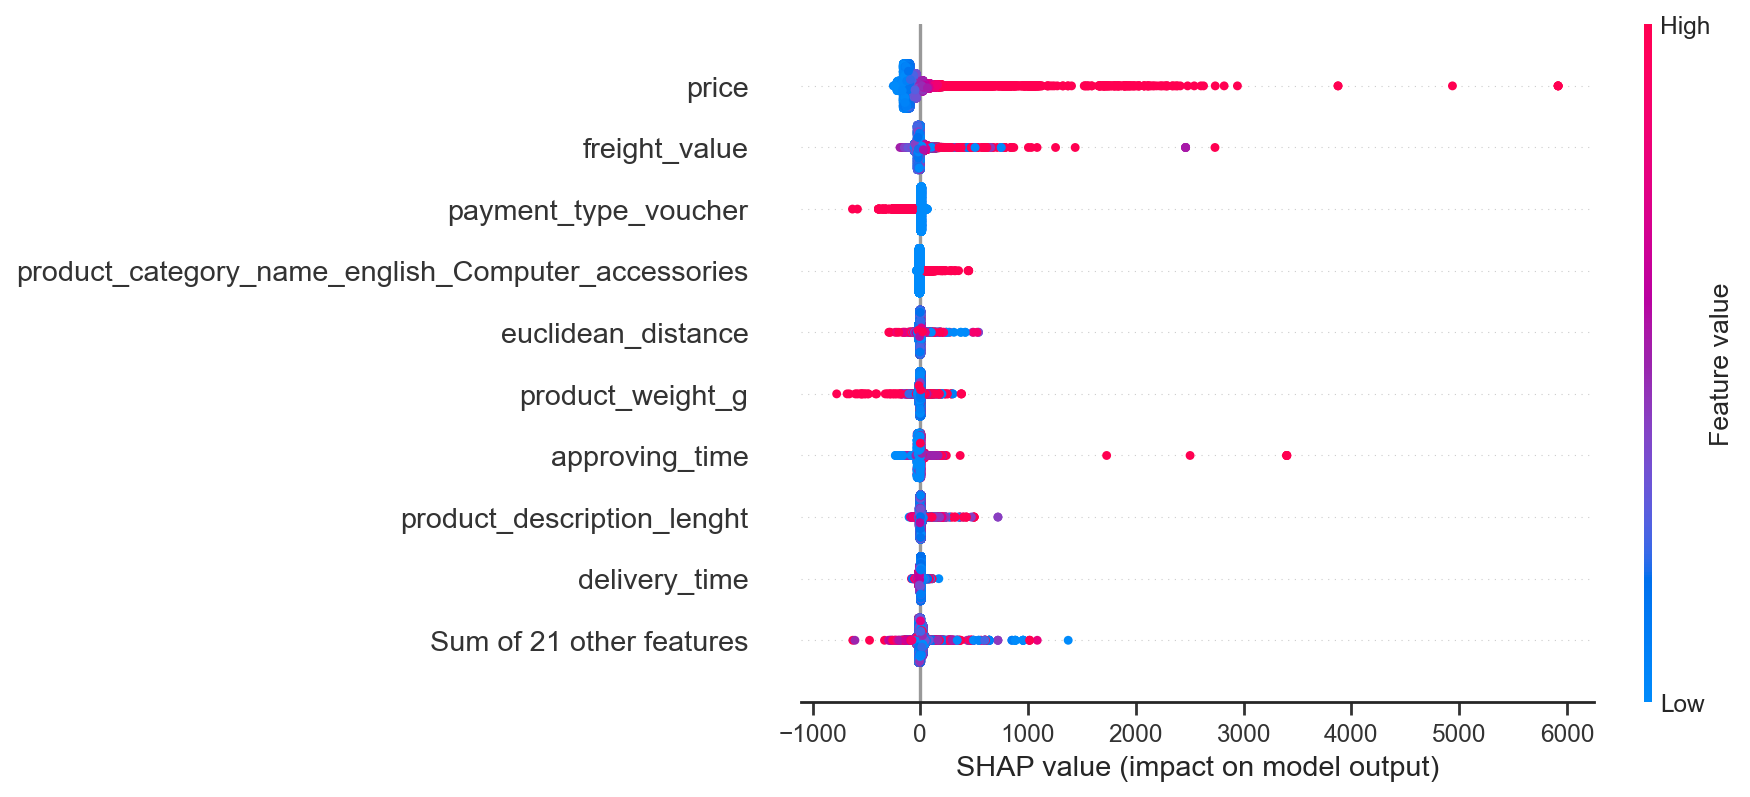

In [83]:
shap.plots.beeswarm(shap_values)
# shap.plots.bar(shap_values)

##### 12. LightGBM

In [41]:
from sklearn.metrics import mean_squared_error as mse
from lightgbm import LGBMRegressor

# Create an instance of the LightGBM Regressor with the RMSE metric.
lightgbm = LGBMRegressor(metric='rmse')

# Train the model using the training data.
lightgbm.fit(X_train, y_train)

# Make predictions on the training and validation data.
# y_train = model.predict(X_train)
# y_val = model.predict(X_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 86103, number of used features: 28
[LightGBM] [Info] Start training from score 172.539958


LGBMRegressor(metric='rmse')

In [45]:
!pip install lightgbm


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


##### Re: Model Evaluation



| Metric | Sensitive to Outliers? | Range       | Ideal Value | Unit |
|--------|------------------------|-------------|-------------|------|
| RMSE   | ✔️ Yes                 | $0$ to $\infty$   | Lower       | Same as target |
| MAE    | ❌ No                  | $0$ to $\infty$    | Lower       | Same as target |
| $R^2$     | ✔️ Yes                 | $-\infty$ to $1$     | Closer to 1 | Unitless |

In [44]:
# Initialize table
columns = ['RMSE', 'R-Squared', 'MAE']
rows = ['Linear Regression', 'Ridge', 'Lasso_CV', 'KNN (k = 5)', 'KNN (k = 15)', 'Model Stacking', 'Decision Tree', 'Bagging',
       'Random Forest (tuned)', 'Gradient Boosting', 'AdaBoost', 'XGBoost', 'lightGBM']

# Define Methods (All models)
methods = [ols, ridge, lasso_cv, knn1, knn2, stack, dt, bag, rf_tuned, gb, ada, xgb, lightgbm]

# checking row-model consistency
print(len(rows))
print(len(methods))

results =pd.DataFrame(0.0, columns=columns, index=rows)
results

13
13


,RMSE,R-Squared,MAE
Linear Regression,0.0,0.0,0.0
Ridge,0.0,0.0,0.0
Lasso_CV,0.0,0.0,0.0
KNN (k = 5),0.0,0.0,0.0
KNN (k = 15),0.0,0.0,0.0
Model Stacking,0.0,0.0,0.0
Decision Tree,0.0,0.0,0.0
Bagging,0.0,0.0,0.0
Random Forest (tuned),0.0,0.0,0.0
Gradient Boosting,0.0,0.0,0.0


In [43]:
# Compute test predictions
#y_pred = np.zeros((len(y_valid), 3))

for i, method in enumerate(methods):
    y_pred = method.predict(X_test)
    # record validation results
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i, 1] = r2_score(y_test, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_test, y_pred)

results.round(3)

,RMSE,R-Squared,MAE
Linear Regression,194.508,0.521,62.498
Ridge,194.508,0.521,62.498
Lasso_CV,194.511,0.521,62.487
KNN (k = 5),177.363,0.602,85.337
KNN (k = 15),226.844,0.349,98.003
Model Stacking,175.828,0.609,64.323
Decision Tree,168.111,0.642,81.388
Bagging,88.502,0.901,32.934
Random Forest (tuned),73.154,0.932,30.342
Gradient Boosting,102.093,0.868,48.675


In [86]:
print(y_test.shape)
print(X_test.shape)
print(X_train.shape)
print(y_train.shape)

(36902,)
(36902, 30)
(86103, 30)
(86103,)


##### Next Steps:

Draft Report:

* Merge Dataset, Inspect every single dataset --> what's in every single dataset, what are some meaningful columns/features?
* EDA on merged dataset:
   1. plotting/data visualization - extract business insights (3-5 findings)
   2. frame business problems?
   3. EDA based on data types: categorical/datetime/numerical data, 分类进行说明和EDA, what you want to do with these variables?
* Modeling Preliminary Steps: (iterative process可以反复尝试做)
   1. pick response variable: regression task? classification task? what are the relevant features
   2. pick feature set: eliminate what features? create new features?
   3. feature engineering: ordinal/one-hot/target encoding, data transformation, check data type, deal with missing values/anomaly data, dealing with class imbalance (for classification task only)
* Modeling:
   1. Pick 3-5 models for draft report: pick baseline model, what are the next steps?
   2. Regression task: linear regression, linear regression with regularization, KNN regressor, Model Stack, Tree-based model - decision tree, Bagging (Random Forest), Boosting (AdaBoost, XGBoost, CatBoost), LightGBM
   3. hyperparameter tuning: Grid search/randomized search CV, using hyperparameter tuning packages: `optuna`
   4. evaluation metrics: loss, SE, AUC-ROC, F1, confusion matrix, cross-entropy

In [ ]:
def regression_models(X_train, y_train):
    """
    params: training feature set, target variable vector
    Call regression models
    """
    alphas = 10 **np.linspace(10, -2, 100) * 0.5
    
    ols = LinearRegression()
    ridge = Ridge(random_state=62)
    lasso_cv = LassoCV(alphas=alphas, cv=5)
    
    lst = [ols, ridge, lasso_cv]

    for clf in lst:
        clf.fit(X_train, y_train)
        print(f"{clf} training set fitted")

regression_models(X_train, y_train)